# 读取数据和引入模块

In [1]:
import sklearn as sk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
# from xgboost import XGBClassifier
from sklearn.metrics import roc_curve
import toad

In [2]:
data_train = pd.read_csv('data_train.csv',index_col = 0) # index_col=0表示以原有数据的第一列(索引为0)当作行索引

In [3]:
x_train = data_train.drop(columns = ['loan_status'])

In [4]:
y_train = data_train['loan_status']

In [5]:
x_train.shape,y_train.shape

((26313, 19), (26313,))

In [6]:
y_train.value_counts()

0    19016
1     7297
Name: loan_status, dtype: int64

In [7]:
data_test = pd.read_csv('data_test.csv',index_col = 0)

In [8]:
x_test = data_test.drop(columns = ['loan_status'])

In [9]:
y_test = data_test['loan_status']

In [10]:
x_test.shape,y_test.shape

((6579, 19), (6579,))

In [11]:
y_test.value_counts()

0    4777
1    1802
Name: loan_status, dtype: int64

# 模型训练

##  网格搜索

In [12]:
 xgb_param={'max_depth':np.arange(3,10,1),'n_estimators':[300,350,400],'learning_rate':list(np.arange(0.01, 0.3, 0.05))}
#树结构最大深度max_depth、树的棵树n_estimators以及学习率learning_rate

xgb_gsearch=GridSearchCV(estimator=xgb.XGBClassifier(random_state=0),#, subsample=0.8, colsample_bytree=0.8
# subsample：浮点型，用于指定每个决策树模型训练需要的样本数。取值范围为(0～1]，即将该值作为比率乘以总样本数，作为训练单
#    个决策树模型的训练样本。增加输入扰动，进而增加模型的多样性。
# colsample_bytree：浮点数，取值范围为(0～1]，用于指定每个决策树模型训练需要的特征数，将该值作为比率乘以总特征数后作为训
#    练单个决策树模型的训练特征
                                param_grid= xgb_param, cv=3,  n_jobs=-1, verbose=2)
#scoring='f1',
# scoring=None:模型评价标准，默认None,这时需要使用score函数；或者如scoring='roc_auc'，根据所选模型不同，评价准则不同
#   (指定损失函数类型)如果是None，则使用estimator的误差估计函数
xgb_gsearch.fit(x_train,y_train)

xgb_gsearch.best_score_, xgb_gsearch.best_params_

Fitting 3 folds for each of 126 candidates, totalling 378 fits


(0.7307414585946109,
 {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 400})

## 训练模型

In [13]:
XGB_model = xgb.XGBClassifier(random_state=0, n_jobs=-1, n_estimators=xgb_gsearch.best_params_['n_estimators'],max_depth=
     xgb_gsearch.best_params_['max_depth'], learning_rate=xgb_gsearch.best_params_['learning_rate'])
# subsample=0.8, colsample_bytree=0.8,
XGB_model_fit = XGB_model.fit(x_train, y_train)

# 预测与评估

## 混淆矩阵

In [14]:
y_pred_test = XGB_model_fit.predict(x_test)

y_pred_train = XGB_model_fit.predict(x_train)   #计算PSI

cnf_matrix = sk.metrics.confusion_matrix(y_test,y_pred_test)
cnf_matrix = pd.DataFrame(cnf_matrix,index = ["标签为好","标签为坏"],columns = ['预测为好','预测为坏'])
cnf_matrix

预测为好  预测为坏
标签为好  4576   201
标签为坏  1541   261

## 评估指标

In [15]:
accuracy=sk.metrics.accuracy_score(y_test,y_pred_test)

y_score=XGB_model_fit.predict_proba(x_test)[:,1]
auc=sk.metrics.roc_auc_score(y_test,y_score)

fpr,tpr,threshold=sk.metrics.roc_curve(y_test,y_score)
ks=max([trp_ - fpr_ for trp_, fpr_ in zip(tpr, fpr)])

psi=toad.metrics.PSI(y_pred_train,y_pred_test)

estimate=pd.DataFrame([[accuracy,auc,ks,psi]],columns=['准确率','AUC','KS值','PSI'])
estimate.index = ['XGBoost']
estimate

准确率       AUC       KS值       PSI
XGBoost  0.735218  0.707608  0.309506  0.000435

## ROC和KS图像

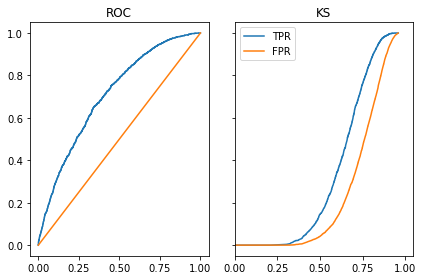

In [16]:
y_proba = XGB_model_fit.predict_proba(x_test)
fig,(axe1,axe2) = plt.subplots(1,2,sharey = True)    # 返回值fig： matplotlib.figure.Figure 对象 
                                                    #ax：子图对象（ matplotlib.axes.Axes）或者是他的数组     
# subplots(nrows=1, ncols=1, sharex=False, sharey=False, squeeze=True,subplot_kw=None, gridspec_kw=None, **fig_kw)
# nrows，ncols：子图的行列数   sharex, sharey：设置为 True 或者 ‘all’ 时，所有子图共享 x 轴或者 y 轴，
# 设置为 False or ‘none’ 时，所有子图的 x，y 轴均为独立，设置为 ‘row’ 时，每一行的子图会共享 x 或者 y 轴，
# 设置为 ‘col’ 时，每一列的子图会共享 x 或者 y 轴。

for i in range(len(np.unique(y_test))):
    fpr,tpr,thresholds = roc_curve(y_test,y_proba[:,i],pos_label = i)
axe1.plot(fpr,tpr)
axe1.plot([0,1],[0,1])
axe1.set_title('ROC')
axe2.plot(1 - thresholds,tpr,label = 'TPR')
axe2.plot(1 - thresholds,fpr,label = 'FPR')
plt.legend()   #plt.legend（）函数主要的作用就是给图加上图例
plt.xlim(0,)   #刻度范围,若不设置，则坐标轴的刻度范围取决于数据中的最大值和最小值,plt.xlim(x.min() - 1.5, x.max() + 1.5)
axe2.set_title('KS')
plt.tight_layout() # tight_layout会自动调整子图参数，使之填充整个图像区域。这是个实验特性，
                    # 可能在一些情况下不工作。它仅仅检查坐标轴标签、刻度标签以及标题的部分
plt.show()